# Results from training on real HPF data

January 2022

gully


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4100, logg=3.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [6]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 11759 spectral lines


In [7]:
emulator.to(device)

SparsePhoenixEmulator()

In [8]:
state_dict_init = emulator.state_dict()

In [9]:
state_dict_init['lam_centers'].shape

torch.Size([11759])

In [10]:
state_dict_post = torch.load('../examples/sparse_T4100g3p5_prom0p01_HPF.pt')

In [11]:
emulator.load_state_dict(state_dict_post)

<All keys matched successfully>

In [12]:
%%time
with torch.no_grad():
    spec_out = emulator.forward().cpu().numpy()

CPU times: user 1.52 s, sys: 977 ms, total: 2.5 s
Wall time: 598 ms


## Read in real data

In [13]:
from muler.hpf import HPFSpectrum

In [14]:
dir = '~/GitHub/star-witness/data/HPF/goldilocks/UT21-3-015/'
dir = os.path.expanduser(dir)
fn = 'Goldilocks_20210919T084302_v1.0_0063.spectra.fits'
raw_data = HPFSpectrum(file=dir+fn, order=5)

In [15]:
data = raw_data.sky_subtract().deblaze().normalize().trim_edges((8,2040))

In [16]:
#data.plot(ylo=0)

In [17]:
wl = emulator.wl_native[emulator.active_mask].numpy()
flux = emulator.flux_native[emulator.active_mask].numpy()

In [18]:
from blase.emulator import EchelleModel

In [19]:
model = EchelleModel(data.spectral_axis.bin_edges.value, emulator.wl_native)

In [21]:
model.to(device)

EchelleModel()

In [22]:
fake_sigma_angs = torch.tensor(0.18)
fake_vsini = torch.tensor(9.1)

with torch.no_grad():
    fake_signal = model.rotational_broaden(emulator.flux_native, fake_sigma_angs)
    fake_signal = model.rotational_broaden(fake_signal, fake_vsini)

In [28]:
vec = torch.arange(-1, 1, 0.01)

In [31]:
vec2 = torch.clamp(vec, 0)

In [33]:
velocity_grid = 299792.458 * model.kernel_grid / model.median_wl
x = velocity_grid / fake_vsini
x2 = x * x

In [38]:
x2 = torch.clamp(x2, max=1)
kernel = torch.where(x2 < 1, 2.0 * torch.sqrt(1.0 - x2), 0.0)

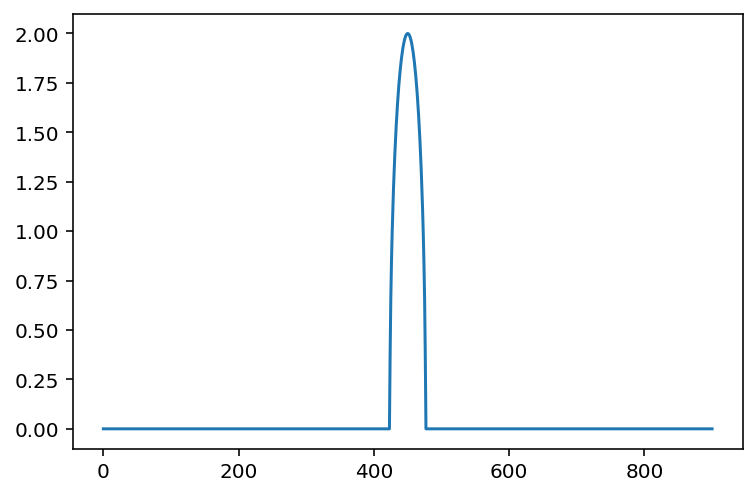

In [40]:
plt.plot(kernel)

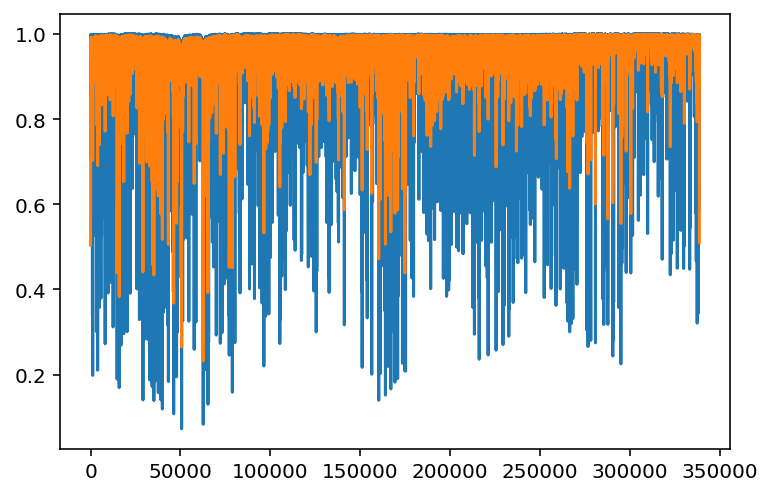

In [24]:
plt.plot(flux_native)
plt.plot(fake_signal)

In [25]:
np.exp(2.89)

17.99330960155032

In [21]:
list(filter(lambda p: p.requires_grad, model.parameters()))

[Parameter containing:
 tensor(-2.3000, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(2.8900, dtype=torch.float64, requires_grad=True)]

In [22]:
output = model.forward(emulator.flux_native)

In [23]:
output

tensor([0.9639, 0.9647, 0.9656,  ..., 0.9754, 0.9760, 0.9765],
       dtype=torch.float64, grad_fn=<SliceBackward>)

In [24]:
output.shape

torch.Size([2031])

In [25]:
output

tensor([0.9639, 0.9647, 0.9656,  ..., 0.9754, 0.9760, 0.9765],
       dtype=torch.float64, grad_fn=<SliceBackward>)

(8656.746484555419, 8767.688497255773)

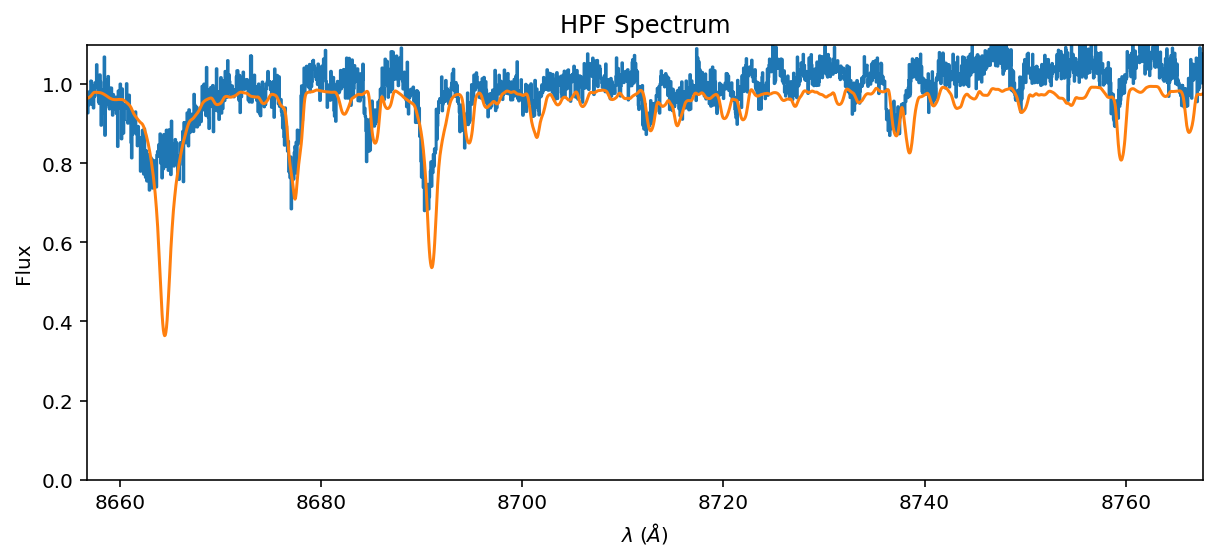

In [30]:
ax = data.plot(ylo=0, yhi=1.1);
#ax.plot(emulator.wl_native, spec_out)
ax.plot(data.wavelength, output.detach().cpu());
ax.set_xlim(data.wavelength.value.min(), data.wavelength.value.max())

Yay! We have doctored the emulator model to work with real data and real astrophysical parameters!

In [35]:
torch.sum(torch.tensor(data.flux.value) - output)

tensor(93.5787, dtype=torch.float64, grad_fn=<SumBackward0>)

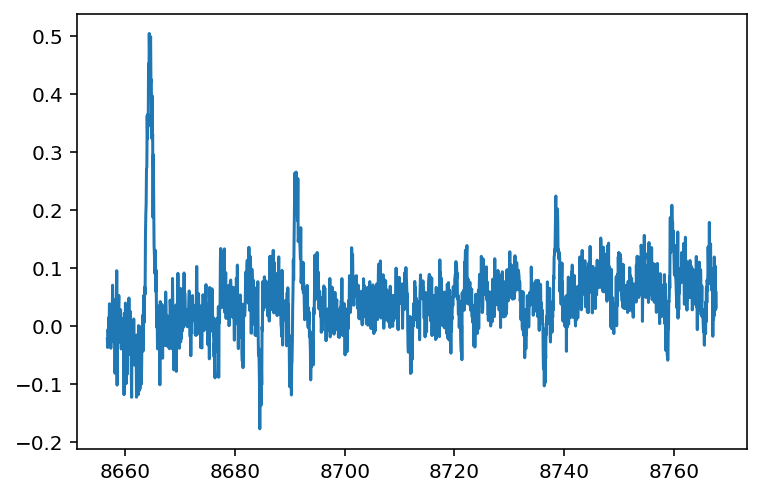

In [37]:
plt.plot(data.wavelength, data.flux.value - output.detach().cpu().numpy());

Awesome, I think we have an efficient way to RV shift, convolve, and bin the spectra!  Next step is running the neural network training!